In [1]:
# Appeding the path to the scaman package
import sys
sys.path.append('/Users/berke/Codes/scaman-2024/scaman') 
# flann path
sys.path.append('/Users/berke/Codes/python/flann/src/python')
import numpy as np

In [7]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import scipy.io as sio

# Load data
X_dict = sio.loadmat('/Users/berke/Codes/scaman-2024/tests/data/salinas/salinasA_corrected.mat')
y_dict = sio.loadmat('/Users/berke/Codes/scaman-2024/tests/data/salinas/salinasA_gt.mat')

print(X_dict.keys())
print(X_dict['salinasA_corrected'].shape)

X = X_dict['salinasA_corrected'].reshape(-1, 204)
y = y_dict['salinasA_gt'].reshape(-1,1)

# Stratified sampling: 10% of the data
X, _, y, _ = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)

dict_keys(['__header__', '__version__', '__globals__', 'salinasA_corrected'])
(83, 86, 204)


In [9]:
#shape of the data
print(X.shape)
print(y.shape)

(713, 204)
(713, 1)


In [10]:
estDim = 8

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from serial.le_flann import LE
from utils.intrinsic_dimension_estimator import Estimator
import time

In [16]:
## Created test with estimated dimension and PCA
start_time_est_le = time.time()
le = LE(X_scaled,n_components=estDim,solver='scipy',slepc_solver='ARNOLDI',affinity='numpy')
embedding_le = le.fit_transform()
end_time_est_le = time.time()
#embedding shape
print(embedding_le.shape)
#embedding type
print(type(embedding_le))
print(f"Time taken: {end_time_est_le - start_time_est_le} seconds")

Computing affinity matrix with numpy and sklearn: 100%|██████████| 713/713 [00:00<00:00, 65304.16it/s]

(713, 8)
<class 'numpy.ndarray'>
Time taken: 0.18040823936462402 seconds


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_le, y, test_size=0.3, random_state=42)

# Fit the KNN model on the training data
start_time_est_knn = time.time()
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train, y_train)
end_time_est_knn = time.time()

# Use the trained model to predict the labels for the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of LE applied data with estDim: {accuracy}")
print(f"Time taken: {end_time_est_knn - start_time_est_knn} seconds")

Accuracy of LE applied data with estDim: 0.822429906542056
Time taken: 0.0013852119445800781 seconds


/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [18]:
time_taken_intrinsic = 0.9005 + (end_time_est_le - start_time_est_le) + (end_time_est_knn - start_time_est_knn)
print(f"Total time taken: {time_taken_intrinsic} seconds")

Total time taken: 1.0841409568786622 seconds


In [26]:
# Split the data into training and testing sets for original data
X_train_org, X_test_org, y_train_org, y_test_org = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
start_time_org_knn = time.time()
# Fit the KNN model on the training data for original data
knn = KNeighborsClassifier(n_neighbors=23)
knn.fit(X_train_org, y_train_org)
end_time_org_knn = time.time()

# Use the trained model to predict the labels for the testing data for original data
y_pred_org = knn.predict(X_test_org)

# Calculate the accuracy of the model for original data
accuracy_org = accuracy_score(y_test_org, y_pred_org)
print(f"Accuracy of original dataset: {accuracy_org}")
print(f"Time taken: {end_time_org_knn - start_time_org_knn} seconds")

Accuracy of original dataset: 0.8317757009345794
Time taken: 0.0014009475708007812 seconds


/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [27]:
# Initialize an empty list to store the accuracies and times
accuracies = []
times = []

# Define the range of dimensions
dimensions = range(2, 20, 2)

# Loop through each dimension
for dim in dimensions:
    start_time = time.time()
    
    # Perform PCA with the current dimension
    le = LE(X_scaled,n_components=dim,solver='scipy',slepc_solver='ARNOLDI',affinity='numpy')
    embedding_le = le.fit_transform()
    #embedding_le = np.real(embedding_le)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(embedding_le, y, test_size=0.3, random_state=42)
    
    # Fit the KNN model on the training data
    knn = KNeighborsClassifier(n_neighbors=23)
    knn.fit(X_train, y_train)
    
    # Use the trained model to predict the labels for the testing data
    y_pred = knn.predict(X_test)
    
    # Calculate the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)
    
    # Append the accuracy to the list
    accuracies.append(accuracy)
    
    end_time = time.time()
    times.append(end_time - start_time)

# Print the accuracies and times for each dimension
for dim, accuracy, time_taken in zip(dimensions, accuracies, times):
    print(f"Dimension: {dim}, Accuracy: {accuracy}, Time taken: {time_taken} seconds")

print(accuracies)
print(times)

Computing affinity matrix with numpy and sklearn: 100%|██████████| 713/713 [00:00<00:00, 263298.01it/s]
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Computing affinity matrix with numpy and sklearn: 100%|██████████| 713/713 [00:00<00:00, 281277.16it/s]
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Computing affinity matrix with numpy and sklearn: 100%|██████████| 713/713 [00:00<00:00, 243093.70it/s]
/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215

Dimension: 2, Accuracy: 0.7897196261682243, Time taken: 0.30368900299072266 seconds
Dimension: 4, Accuracy: 0.7897196261682243, Time taken: 0.17567014694213867 seconds
Dimension: 6, Accuracy: 0.8317757009345794, Time taken: 0.12709712982177734 seconds
Dimension: 8, Accuracy: 0.822429906542056, Time taken: 0.134443998336792 seconds
Dimension: 10, Accuracy: 0.8317757009345794, Time taken: 0.1408529281616211 seconds
Dimension: 12, Accuracy: 0.8317757009345794, Time taken: 0.14306282997131348 seconds
Dimension: 14, Accuracy: 0.8364485981308412, Time taken: 0.1358792781829834 seconds
Dimension: 16, Accuracy: 0.8317757009345794, Time taken: 0.12633204460144043 seconds
Dimension: 18, Accuracy: 0.8271028037383178, Time taken: 0.1248009204864502 seconds
[0.7897196261682243, 0.7897196261682243, 0.8317757009345794, 0.822429906542056, 0.8317757009345794, 0.8317757009345794, 0.8364485981308412, 0.8317757009345794, 0.8271028037383178]
[0.30368900299072266, 0.17567014694213867, 0.12709712982177734, 0

/opt/homebrew/anaconda3/envs/scaman-env/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [28]:
time_taken_loop = np.sum(times)
print(f"Total time taken: {np.sum(times)} seconds")

Total time taken: 1.4118282794952393 seconds


In [29]:
print(accuracies)

[0.7897196261682243, 0.7897196261682243, 0.8317757009345794, 0.822429906542056, 0.8317757009345794, 0.8317757009345794, 0.8364485981308412, 0.8317757009345794, 0.8271028037383178]


In [30]:
# Create lists of dimensions and accuracies
dimensions = list(range(2, 20, 2))


In [31]:
dimensions.append(estDim)
accuracies.append(accuracy)

/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_35855/3613014485.py:7: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "bo-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='LE Dimensions')
/var/folders/yj/rxsr79ls6fx9ykhgjv_fbk2r0000gp/T/ipykernel_35855/3613014485.py:37: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


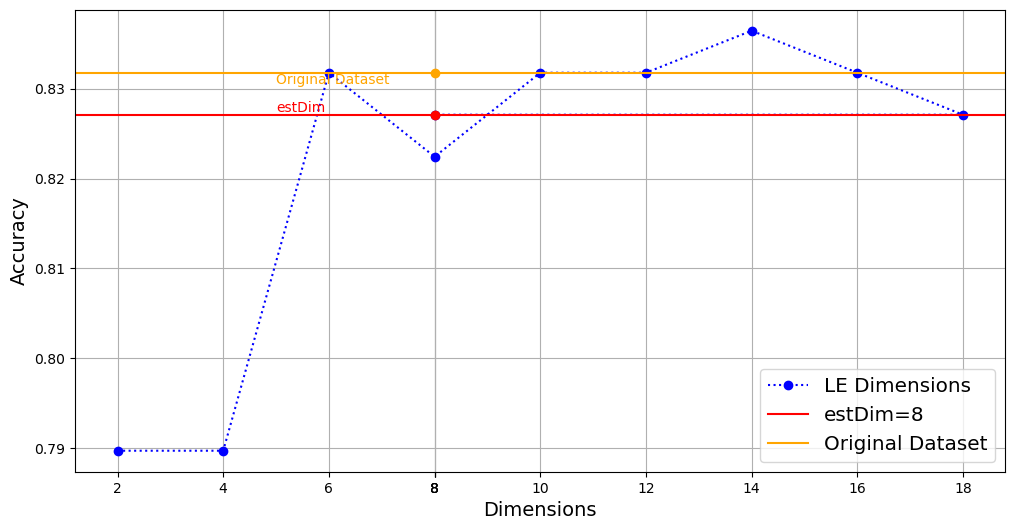

In [32]:
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(12, 6))  # Width: 18 inches, Height: 6 inches

# Create a blue dotted line plot of dimensions vs accuracies with markers
plt.plot(dimensions, accuracies, 'bo-', linestyle='dotted', label='LE Dimensions')

# Highlight the accuracy of estDim with a straight red line
plt.axhline(y=accuracy, color='red', linestyle='-', label=f'estDim={estDim}')
plt.text(5, accuracy, 'estDim', verticalalignment='bottom', color='red')

# Plot the accuracy of the original data with a straight orange line
plt.axhline(y=accuracy_org, color='orange', linestyle='-', label='Original Dataset')
plt.text(5, accuracy_org, 'Original Dataset', verticalalignment='top', color='orange')

# Highlight the intersection point at estimated dimension
# Plot these after the blue line to ensure they appear on top
plt.scatter(estDim, accuracy, color='red', zorder=5)
plt.scatter(estDim, accuracy_org, color='orange', zorder=5)

# Add grid
plt.grid(True)

# Set x-axis to show all dimensions
plt.xticks(dimensions + [estDim])

# Label the axes and create a legend
plt.xlabel('Dimensions', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
#plt.title('Indian Pines - PCA and kNN Accuracies with Dimension Estimator', fontsize=16)

# Create a legend with larger font size
legend = plt.legend(fontsize='x-large')

# Increase the size of the legend markers
for handle in legend.legendHandles:
    handle._sizes = [85]

plt.show()